# Residual Networks

Welcome to the second assignment of this week! You will learn how to build very deep convolutional networks, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously practically feasible.

**In this assignment, you will:**
- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

## <font color='darkblue'>Updates</font>

#### If you were working on the notebook before this update...
* The current notebook is version "2a".
* You can find your original work saved in the notebook with the previous version name ("v2") 
* To view the file directory, go to the menu "File->Open", and this will open a new tab that shows the file directory.

#### List of updates
* For testing on an image, replaced `preprocess_input(x)` with `x=x/255.0` to normalize the input image in the same way that the model's training data was normalized.
* Refers to "shallower" layers as those layers closer to the input, and "deeper" layers as those closer to the output (Using "shallower" layers instead of "lower" or "earlier").
* Added/updated instructions.


This assignment will be done in Keras. 

Before jumping into the problem, let's run the cell below to load the required packages.

In [2]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

## 1 - The problem of very deep neural networks

Last week, you built your first convolutional neural network. In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 
* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow. 
* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 
* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds: 

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

You are now going to solve this problem by building a Residual Network!

## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
(There is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more so than skip connections helping with vanishing gradients).

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### 2.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here are the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. 
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [BatchNormalization](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the 'channels' axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://keras.io/layers/merge/#add)

In [3]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [4]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]


**Expected Output**:

<table>
    <tr>
        <td>
            **out**
        </td>
        <td>
           [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]
        </td>
    </tr>

</table>

## 2.2 - The convolutional block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the `glorot_uniform` seed.
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.  Use 0 as the `glorot_uniform` seed.
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.  Use 0 as the `glorot_uniform` seed.
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.  Use 0 as the `glorot_uniform` seed.
- The BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest. As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- [BatchNormalization](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://keras.io/layers/merge/#add)

In [7]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.09018463  1.23489773  0.46822017  0.0367176   0.          0.65516603]


**Expected Output**:

<table>
    <tr>
        <td>
            **out**
        </td>
        <td>
           [ 0.09018463  1.23489773  0.46822017  0.0367176   0.          0.65516603]
        </td>
    </tr>

</table>

## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The 'flatten' layer doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

**Exercise**: Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2.) Make sure you follow the naming convention in the text above. 

You'll need to use this function: 
- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully connected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [9]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph. If your implementation is not correct you will know it by checking your accuracy when running `model.fit(...)` below.

In [10]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

As seen in the Keras Tutorial Notebook, prior training a model, you need to configure the learning process by compiling the model.

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need is a dataset.

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SIGNS dataset** </center></caption>


In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run the following cell to train your model on 2 epochs with a batch size of 32. On a CPU it should take you around 5min per epoch. 

In [13]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 268s - loss: 2.3847 - acc: 0.3685   
Epoch 2/2
1080/1080 [==============================] - 264s - loss: 1.4836 - acc: 0.5676   


**Expected Output**:

<table>
    <tr>
        <td>
            ** Epoch 1/2**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different from ours.
        </td>
    </tr>
    <tr>
        <td>
            ** Epoch 2/2**
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, you should see your loss decreasing and the accuracy increasing.
        </td>
    </tr>

</table>

Let's see how this model (trained on only two epochs) performs on the test set.

In [14]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 9s     
Loss = 2.09466609955
Test Accuracy = 0.199999998013


**Expected Output**:

<table>
    <tr>
        <td>
            **Test Accuracy**
        </td>
        <td>
           between 0.16 and 0.25
        </td>
    </tr>

</table>

For the purpose of this assignment, we've asked you to train the model for just two epochs. You can see that it achieves poor performances. Please go ahead and submit your assignment; to check correctness, the online grader will run your code only for a small number of epochs as well.

After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. We get a lot better performance when we train for ~20 epochs, but this will take more than an hour when training on a CPU. 

Using a GPU, we've trained our own ResNet50 model's weights on the SIGNS dataset. You can load and run our trained model on the test set in the cells below. It may take ≈1min to load the model.

In [15]:
model = load_model('ResNet50.h5') 

In [16]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 9s     
Loss = 0.530178320408
Test Accuracy = 0.866666662693


ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. We hope you can use what you've learnt and apply it to your own classification problem to perform state-of-the-art accuracy.

Congratulations on finishing this assignment! You've now implemented a state-of-the-art image classification system! 

## 4 - Test on your own image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[  6.57442666e-04   3.53990612e-03   9.40259814e-01   8.54844188e-07
    5.55267259e-02   1.53390301e-05]]


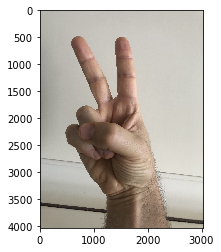

In [17]:
img_path = 'images/amir_hand_two.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

You can also print a summary of your model by running the following code.

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

Finally, run the code below to visualize your ResNet50. You can also download a .png picture of your model by going to "File -> Open...-> model.png".

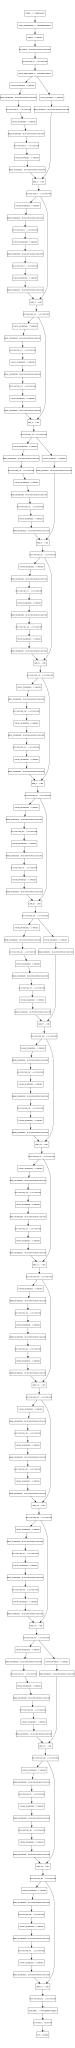

In [19]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## What you should remember
- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The identity block and the convolutional block. 
- Very deep Residual Networks are built by stacking these blocks together.

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
